In [1]:
import os

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from magneton.data.dataset import get_protein_dataset
from magneton.io.internal import shard_proteins

In [2]:
# The following files contain the FoldSeek sequence-based clusters (AFDB50) and structure-based
# clusters (FoldSeek-Cluster), subset to only include SwissProt proteins.
data_dir = "/weka/scratch/weka/kellislab/rcalef/data"
interpro_dir = os.path.join(
    data_dir,
    "interpro",
    "103.0",
    "swissprot",
    "sharded_swissprot",
    "with_ss",
)


foldseek_dir = os.path.join(data_dir, "foldseek_cluster")
seq_cluster_path = os.path.join(foldseek_dir, "afdb50_clusters_swissprot.tsv")
struct_cluster_path = os.path.join(foldseek_dir, "foldseek_clusters_swissprot.tsv")

In [3]:
# `rep_id` gives the UniProt ID of the representative for the cluster, `uniprot_id` gives
# the UniProt ID for the actual individual protein. File has an extraneous blank column.
seq_cluster_assignments = pd.read_table(seq_cluster_path, names=["rep_id", "uniprot_id", "X"]).drop(columns=["X"])
seq_cluster_assignments.head()

,rep_id,uniprot_id
0,A0A1Z5LF99,Q7JYV2
1,B9LLY0,B9LLY0
2,B9LLY0,A9WHT8
3,P07316,A3RLE1
4,P07316,P04344


In [4]:
# `rep_id` gives the UniProt ID of the representative for the cluster, `uniprot_id` gives
# the UniProt ID for the actual individual protein.
# `clust_type` describes the reason the protein is included in the cluster (i.e. based on sequence or structure),
# or whether or not FoldSeek authors excluded it and why.
# `tax_id` is just taxonomic ID for organism
# See description for file `5-allmembers-repId-entryId-cluFlag-taxId.tsv.gz` here:
#  https://afdb-cluster.steineggerlab.workers.dev/

struct_cluster_assignments = (
    pd.read_table(struct_cluster_path, names=["rep_id", "uniprot_id", "clust_type", "tax_id"])
    .assign(
        clust_type=lambda x: x.clust_type.map({
            1: "seq_clust",
            2: "struct_clust",
            3: "fragments",
            4: "singleton",
        })
    )
)
struct_cluster_assignments.head()

,rep_id,uniprot_id,clust_type,tax_id
0,A0A009J8A1,P0ACU7,seq_clust,83333
1,A0A009J8A1,P0ACU8,seq_clust,199310
2,A0A009J8A1,P0ACU9,seq_clust,623
3,A0A010QBH7,P87145,struct_clust,284812
4,A0A010R299,Q2U1H5,struct_clust,510516


In [5]:
struct_cluster_assignments.clust_type.value_counts()

clust_type
seq_clust       439154
struct_clust     95602
singleton         9477
fragments         3552
Name: count, dtype: int64

In [6]:
prot_dataset = get_protein_dataset(interpro_dir, prefix="swissprot.with_ss")
prots = list(prot_dataset)
dataset_ids = pd.Series([x.uniprot_id for x in prots])
len(dataset_ids)

530601

In [7]:
dataset_ids.isin(seq_cluster_assignments.uniprot_id).value_counts()

True    530601
Name: count, dtype: int64

In [8]:
dataset_ids.isin(struct_cluster_assignments.uniprot_id).value_counts()

True    530601
Name: count, dtype: int64

In [9]:
(
    struct_cluster_assignments
    .loc[lambda x: x.uniprot_id.isin(dataset_ids)]
    .clust_type.value_counts()
)

clust_type
seq_clust       430991
struct_clust     92059
singleton         4962
fragments         2589
Name: count, dtype: int64

## Make structure-based splits

In [10]:
# Set the random seed for reproducibility
np.random.seed(42)

# Get the unique cluster identifiers
cluster_ids = struct_cluster_assignments['rep_id'].unique()

# Shuffle the cluster identifiers randomly
np.random.shuffle(cluster_ids)

# Calculate the number of clusters for each split
total_clusters = len(cluster_ids)
train_clusters_count = int(0.8 * total_clusters)
val_clusters_count = int(0.1 * total_clusters)
test_clusters_count = total_clusters - train_clusters_count - val_clusters_count

# Split the shuffled cluster identifiers into three sets
train_clusters = cluster_ids[:train_clusters_count]
val_clusters = cluster_ids[train_clusters_count:train_clusters_count+val_clusters_count]
test_clusters = cluster_ids[train_clusters_count+val_clusters_count:]

# Filter the struct_cluster_assignments dataframe based on the cluster splits
train_data = struct_cluster_assignments[struct_cluster_assignments['rep_id'].isin(train_clusters)]
val_data = struct_cluster_assignments[struct_cluster_assignments['rep_id'].isin(val_clusters)]
test_data = struct_cluster_assignments[struct_cluster_assignments['rep_id'].isin(test_clusters)]

# Get the corresponding datapoints for each split
train_datapoints = dataset_ids[dataset_ids.isin(train_data['uniprot_id'])]
val_datapoints = dataset_ids[dataset_ids.isin(val_data['uniprot_id'])]
test_datapoints = dataset_ids[dataset_ids.isin(test_data['uniprot_id'])]

# Print total number of clusters and datapoints per split
def summary(name, clusters_count, split_datapoints):
    print(f"{name} clusters: {clusters_count}, datapoints: {len(split_datapoints)} ({len(split_datapoints) / len(dataset_ids) * 100:.2f}%) proteins per cluster: {len(split_datapoints) / clusters_count:.2f}")
summary("Train", train_clusters_count, train_datapoints)
summary("Val", val_clusters_count, val_datapoints)
summary("Test", test_clusters_count, test_datapoints)

Train clusters: 59400, datapoints: 423821 (79.88%) proteins per cluster: 7.14
Val clusters: 7425, datapoints: 52623 (9.92%) proteins per cluster: 7.09
Test clusters: 7426, datapoints: 54157 (10.21%) proteins per cluster: 7.29


In [11]:
# Confirm train, val, and test sets are disjoint
assert len(set(train_datapoints) & set(val_datapoints)) == 0
assert len(set(train_datapoints) & set(test_datapoints)) == 0

# Confirm all datapoints have been assigned to one of the splits
assert len(set(train_datapoints)) + len(set(val_datapoints)) + len(set(test_datapoints)) == len(set(dataset_ids))

In [12]:
outdir = os.path.join(interpro_dir, "dataset_splits", "struct_splits")
os.makedirs(outdir, exist_ok=True)

splits = {
    "train": train_datapoints,
    "val": val_datapoints,
    "test": test_datapoints,
}
lookups = {k:set(v) for k,v in splits.items()}

all_splits = []
split_prots = defaultdict(list)

for prot in prots:
    for split, lookup in lookups.items():
        if prot.uniprot_id in lookup:
            split_prots[split].append(prot)
            break


for split_name, datapoints in splits.items():
    all_splits.append(
        datapoints.rename("uniprot_id").to_frame().assign(split=split_name)
    )

    split_dir = os.path.join(outdir, f"{split_name}_sharded")
    os.makedirs(split_dir, exist_ok=True)
    shard_proteins(
        split_prots[split_name],
        split_dir,
        prefix=f"swissprot.with_ss.{split_name}",
        prots_per_file=10000,
    )

all_splits = pd.concat(all_splits)
all_splits.to_csv(os.path.join(outdir, "dataset_splits.tsv"), index=False, sep="\t")

completed file 1, starting file 2
completed file 2, starting file 3
completed file 3, starting file 4
completed file 4, starting file 5
completed file 5, starting file 6
completed file 6, starting file 7
completed file 7, starting file 8
completed file 8, starting file 9
completed file 9, starting file 10
completed file 10, starting file 11
completed file 11, starting file 12
completed file 12, starting file 13
completed file 13, starting file 14
completed file 14, starting file 15
completed file 15, starting file 16
completed file 16, starting file 17
completed file 17, starting file 18
completed file 18, starting file 19
completed file 19, starting file 20
completed file 20, starting file 21
completed file 21, starting file 22
completed file 22, starting file 23
completed file 23, starting file 24
completed file 24, starting file 25
completed file 25, starting file 26
completed file 26, starting file 27
completed file 27, starting file 28
completed file 28, starting file 29
completed

## Make sequence-based splits

In [13]:
seq_cluster_assignments.head()

,rep_id,uniprot_id
0,A0A1Z5LF99,Q7JYV2
1,B9LLY0,B9LLY0
2,B9LLY0,A9WHT8
3,P07316,A3RLE1
4,P07316,P04344


In [14]:
# Set the random seed for reproducibility
np.random.seed(42)

# Get the unique cluster identifiers
cluster_ids = seq_cluster_assignments['rep_id'].unique()

# Shuffle the cluster identifiers randomly
np.random.shuffle(cluster_ids)

# Calculate the number of clusters for each split
total_clusters = len(cluster_ids)
train_clusters_count = int(0.8 * total_clusters)
val_clusters_count = int(0.1 * total_clusters)
test_clusters_count = total_clusters - train_clusters_count - val_clusters_count

# Split the shuffled cluster identifiers into three sets
train_clusters = cluster_ids[:train_clusters_count]
val_clusters = cluster_ids[train_clusters_count:train_clusters_count+val_clusters_count]
test_clusters = cluster_ids[train_clusters_count+val_clusters_count:]

# Filter the seq_cluster_assignments dataframe based on the cluster splits
train_data = seq_cluster_assignments[seq_cluster_assignments['rep_id'].isin(train_clusters)]
val_data = seq_cluster_assignments[seq_cluster_assignments['rep_id'].isin(val_clusters)]
test_data = seq_cluster_assignments[seq_cluster_assignments['rep_id'].isin(test_clusters)]

# Get the corresponding datapoints for each split
train_datapoints = dataset_ids[dataset_ids.isin(train_data['uniprot_id'])]
val_datapoints = dataset_ids[dataset_ids.isin(val_data['uniprot_id'])]
test_datapoints = dataset_ids[dataset_ids.isin(test_data['uniprot_id'])]

# Print total number of clusters and datapoints per split
def summary(name, clusters_count, split_datapoints):
    print(f"{name} clusters: {clusters_count}, datapoints: {len(split_datapoints)} ({len(split_datapoints) / len(dataset_ids) * 100:.2f}%) proteins per cluster: {len(split_datapoints) / clusters_count:.2f}")
summary("Train", train_clusters_count, train_datapoints)
summary("Val", val_clusters_count, val_datapoints)
summary("Test", test_clusters_count, test_datapoints)

Train clusters: 168567, datapoints: 423885 (79.89%) proteins per cluster: 2.51
Val clusters: 21070, datapoints: 53587 (10.10%) proteins per cluster: 2.54
Test clusters: 21072, datapoints: 53129 (10.01%) proteins per cluster: 2.52


In [15]:
# Confirm train, val, and test sets are disjoint
assert len(set(train_datapoints) & set(val_datapoints)) == 0
assert len(set(train_datapoints) & set(test_datapoints)) == 0

# Confirm all datapoints have been assigned to one of the splits
assert len(set(train_datapoints)) + len(set(val_datapoints)) + len(set(test_datapoints)) == len(set(dataset_ids))

In [16]:
outdir = os.path.join(interpro_dir, "dataset_splits", "seq_splits")
os.makedirs(outdir, exist_ok=True)

splits = {
    "train": train_datapoints,
    "val": val_datapoints,
    "test": test_datapoints,
}
lookups = {k:set(v) for k,v in splits.items()}

all_splits = []
split_prots = defaultdict(list)

for prot in prots:
    for split, lookup in lookups.items():
        if prot.uniprot_id in lookup:
            split_prots[split].append(prot)
            break


for split_name, datapoints in splits.items():
    all_splits.append(
        datapoints.rename("uniprot_id").to_frame().assign(split=split_name)
    )

    split_dir = os.path.join(outdir, f"{split_name}_sharded")
    os.makedirs(split_dir, exist_ok=True)
    shard_proteins(
        split_prots[split_name],
        split_dir,
        prefix=f"swissprot.with_ss.{split_name}",
        prots_per_file=10000,
    )

all_splits = pd.concat(all_splits)
all_splits.to_csv(os.path.join(outdir, "dataset_splits.tsv"), index=False, sep="\t")

completed file 1, starting file 2
completed file 2, starting file 3
completed file 3, starting file 4
completed file 4, starting file 5
completed file 5, starting file 6
completed file 6, starting file 7
completed file 7, starting file 8
completed file 8, starting file 9
completed file 9, starting file 10
completed file 10, starting file 11
completed file 11, starting file 12
completed file 12, starting file 13
completed file 13, starting file 14
completed file 14, starting file 15
completed file 15, starting file 16
completed file 16, starting file 17
completed file 17, starting file 18
completed file 18, starting file 19
completed file 19, starting file 20
completed file 20, starting file 21
completed file 21, starting file 22
completed file 22, starting file 23
completed file 23, starting file 24
completed file 24, starting file 25
completed file 25, starting file 26
completed file 26, starting file 27
completed file 27, starting file 28
completed file 28, starting file 29
completed

## Label distribution by split

In [17]:
want_types = [
    "Family",
    "Domain",
    "Homologous_superfamily",
    "Conserved_site",
    #"Repeat",
    "Active_site",
    "Binding_site",
    "PTM",
]


# Get subset of annotations that we're actually using
label_dir = "/weka/scratch/weka/kellislab/rcalef/data/interpro/103.0/label_sets/selected_subset"
labels = []
for type in want_types:
    path = os.path.join(label_dir, f"{type}.labels.tsv")
    labels.append(pd.read_table(path).assign(element_type=type))
labels = pd.concat(labels)
labels.head()

,label,element_name,interpro_id,element_type
0,0,"Metallothionein, vertebrate",IPR000006,Family
1,1,SsrA-binding protein,IPR000037,Family
2,2,Adenosylhomocysteinase-like,IPR000043,Family
3,3,Thymidine/pyrimidine-nucleoside phosphorylase,IPR000053,Family
4,4,Large ribosomal subunit protein eL31,IPR000054,Family


In [18]:
# Get stats from the full dataset for coverage metrics
stats_dir = os.path.join(
    data_dir,
    "interpro",
    "103.0",
    "swissprot",
    "summary_stats",
)

full_dataset_stats = []
for type in want_types:
    full_dataset_stats.append(
        pd.read_table(os.path.join(stats_dir, f"{type}_summaries.tsv"))
        .assign(
            element_type=type,
        )
    )
full_dataset_stats = pd.concat(full_dataset_stats)

full_dataset_stats.head()

,element_id,element_name,count,max_occurences,min_len,max_len,avg_len,min_num_segs,max_num_segs,avg_num_segs,avg_coverage,element_type
0,IPR000003,Retinoid X receptor/HNF4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Family
1,IPR000006,"Metallothionein, vertebrate",253,2,39.0,67.0,59.715415,1.0,1.0,1.0,0.981059,Family
2,IPR000009,Protein phosphatase 2A regulatory subunit PR55,40,1,411.0,525.0,453.150000,1.0,1.0,1.0,0.979235,Family
3,IPR000011,Ubiquitin/SUMO-activating enzyme E1-like,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Family
4,IPR000012,Retroviral VpR/VpX protein,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Family


In [19]:
labels.element_type.value_counts()

element_type
Family                    1353
Homologous_superfamily    1133
Domain                     917
Conserved_site             356
Active_site                 82
Binding_site                48
PTM                          6
Name: count, dtype: int64

### Struct splits

In [20]:
stats_dir_template = os.path.join(
    interpro_dir,
    "dataset_splits",
    "struct_splits",
    "%s_sharded",
    "summary_stats",
)

def load_stats(interpro_type: str, split_name: str) -> pd.DataFrame:
    stats_path = os.path.join(stats_dir_template % split_name, f"{interpro_type}_summaries.tsv")
    return pd.read_table(stats_path)

In [21]:
def load_stats_one_split(split_name: str) -> pd.DataFrame:
    stats = []
    for interpro_type in want_types:
        stats.append(
            load_stats(interpro_type, split_name)
            .assign(
                element_type=interpro_type,
            )
        )
    return (pd.concat(stats)
            [["element_id", "element_name", "element_type", "count"]]
            .rename(columns={"count": f"{split_name}_count"})
            .loc[lambda x: x.element_id.isin(labels.interpro_id)])

combined_counts = None
for split_name in ["train", "val", "test"]:
    counts = load_stats_one_split(split_name)
    if combined_counts is None:
        combined_counts = counts
    else:
        combined_counts = combined_counts.merge(counts, on=["element_id", "element_name", "element_type"])


combined_counts.head()

,element_id,element_name,element_type,train_count,val_count,test_count
0,IPR000006,"Metallothionein, vertebrate",Family,129,124,0
1,IPR000037,SsrA-binding protein,Family,1419,0,0
2,IPR000043,Adenosylhomocysteinase-like,Family,438,0,68
3,IPR000053,Thymidine/pyrimidine-nucleoside phosphorylase,Family,125,0,0
4,IPR000054,Large ribosomal subunit protein eL31,Family,168,2,0


In [22]:
combined_counts = (
    combined_counts
    .assign(
        total_count=lambda x: x[["train_count", "val_count", "test_count"]].sum(axis=1),
        train_frac=lambda x: x.train_count / x.total_count,
        deviation=lambda x: x.train_frac - 0.8,
    )
    .merge(full_dataset_stats[["element_id", "avg_coverage"]], on="element_id")
)
combined_counts.head()


,element_id,element_name,element_type,train_count,val_count,test_count,total_count,train_frac,deviation,avg_coverage
0,IPR000006,"Metallothionein, vertebrate",Family,129,124,0,253,0.509881,-0.290119,0.981059
1,IPR000037,SsrA-binding protein,Family,1419,0,0,1419,1.000000,0.200000,0.865631
2,IPR000043,Adenosylhomocysteinase-like,Family,438,0,68,506,0.865613,0.065613,0.978624
3,IPR000053,Thymidine/pyrimidine-nucleoside phosphorylase,Family,125,0,0,125,1.000000,0.200000,0.983635
4,IPR000054,Large ribosomal subunit protein eL31,Family,168,2,0,170,0.988235,0.188235,0.874238


In [23]:
combined_counts.groupby("element_type").train_frac.describe()

,count,mean,std,min,25%,50%,75%,max
element_type,,,,,,,,
Active_site,82.0,0.713959,0.262474,0.148936,0.583550,0.771818,0.952018,1.0
Binding_site,48.0,0.759663,0.256975,0.136986,0.674879,0.852661,0.958744,1.0
Conserved_site,356.0,0.807920,0.227506,0.000000,0.694071,0.910580,0.986739,1.0
Domain,917.0,0.796782,0.235510,0.000000,0.723348,0.866667,0.970588,1.0
Family,1353.0,0.791080,0.292170,0.000000,0.693333,0.944354,0.998012,1.0
Homologous_superfamily,1133.0,0.805794,0.213635,0.000000,0.722772,0.863842,0.965517,1.0
PTM,6.0,0.803303,0.124720,0.686469,0.706299,0.777086,0.866629,1.0


/tmp/ipykernel_3849308/610741490.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.stripplot(


Text(0.5, 0, 'Entry type')

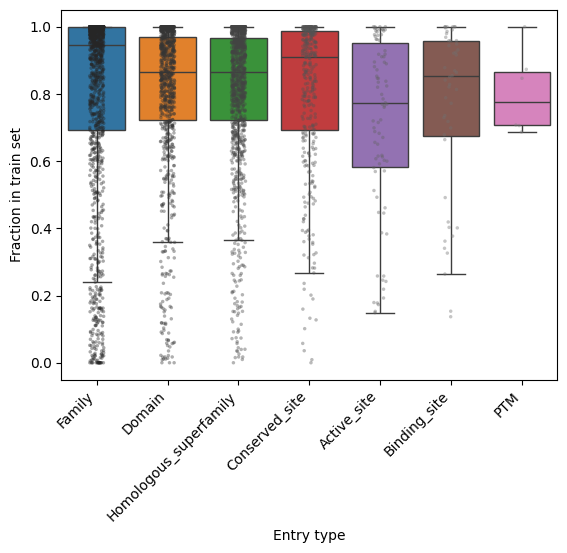

In [24]:
sns.boxplot(
    x="element_type",
    y="train_frac",
    hue="element_type",
    data=combined_counts,
    hue_order=want_types,
    fliersize=0,
)
sns.stripplot(
    x="element_type",
    y="train_frac",
    hue="element_type",
    data=combined_counts,
    hue_order=want_types,
    marker=".",
    alpha=0.4,
    color="grey",
)


plt.xticks(rotation=45, ha="right")
plt.ylabel("Fraction in train set")
plt.xlabel("Entry type")

Text(0.5, 0, 'Entry type')

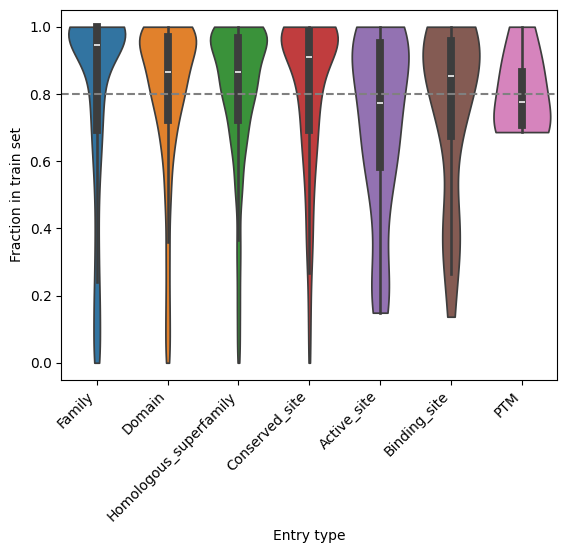

In [25]:
sns.violinplot(
    x="element_type",
    y="train_frac",
    hue="element_type",
    data=combined_counts,
    hue_order=want_types,
    cut=0,
)
plt.axhline(0.8, color="gray", linestyle='--')

plt.xticks(rotation=45, ha="right")
plt.ylabel("Fraction in train set")
plt.xlabel("Entry type")

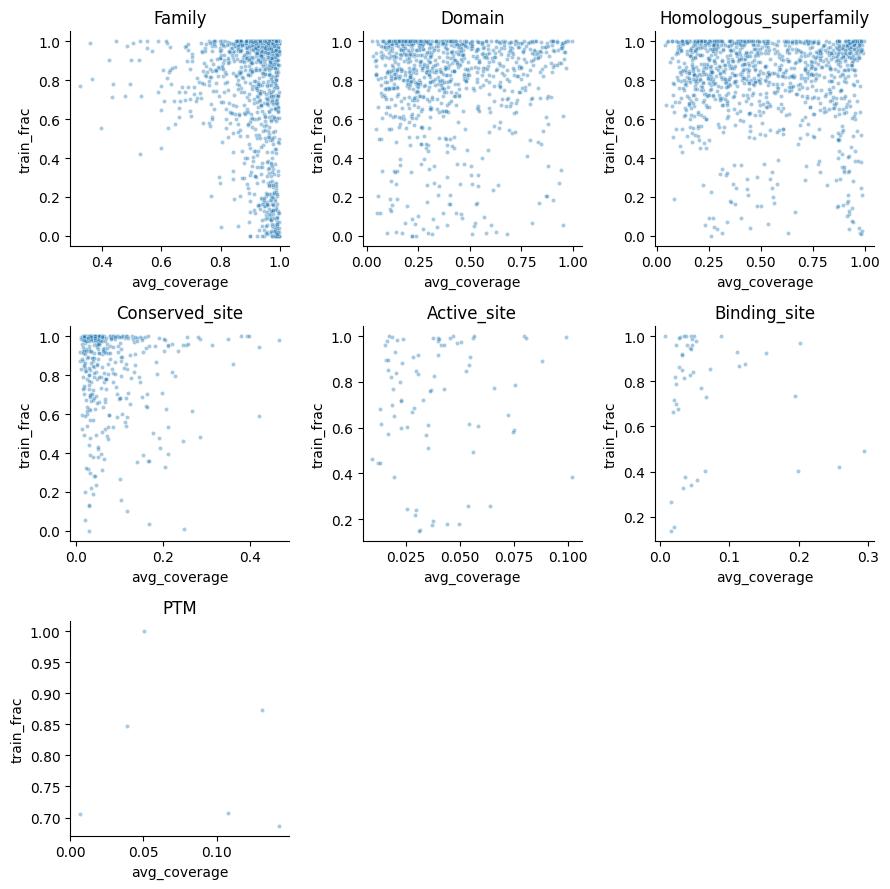

In [26]:
# Create a FacetGrid
g = sns.FacetGrid(combined_counts, col="element_type", col_wrap=3, sharex=False, sharey=False)

# Define the plotting function
def plot_facet(data, **kwargs):
    elem_type = data['element_type'].iloc[0]

    sns.scatterplot(
        x="avg_coverage",
        y="train_frac",
        marker=".",
        alpha=0.4,
        data=data,
        **kwargs,
    )
    plt.title(elem_type)

# Map the plotting function to each facet
g.map_dataframe(plot_facet)

# Adjust titles to show only the element type
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title)

#plt.suptitle("Unique elements by threshold")

# Adjust layout
plt.tight_layout()
plt.show()

In [27]:
x = combined_counts.query("element_type == 'Domain'")[["train_count", "val_count", "test_count"]].sum()
x / x.sum()

train_count    0.796287
val_count      0.093429
test_count     0.110284
dtype: float64

### Seq splits

In [28]:
stats_dir_template = os.path.join(
    interpro_dir,
    "dataset_splits",
    "seq_splits",
    "%s_sharded",
    "summary_stats",
)

def load_stats(interpro_type: str, split_name: str) -> pd.DataFrame:
    stats_path = os.path.join(stats_dir_template % split_name, f"{interpro_type}_summaries.tsv")
    return pd.read_table(stats_path)

In [29]:
def load_stats_one_split(split_name: str) -> pd.DataFrame:
    stats = []
    for interpro_type in want_types:
        stats.append(
            load_stats(interpro_type, split_name)
            .assign(
                element_type=interpro_type,
            )
        )
    return (pd.concat(stats)
            [["element_id", "element_name", "element_type", "count"]]
            .rename(columns={"count": f"{split_name}_count"})
            .loc[lambda x: x.element_id.isin(labels.interpro_id)])

combined_counts_seq = None
for split_name in ["train", "val", "test"]:
    counts = load_stats_one_split(split_name)
    if combined_counts_seq is None:
        combined_counts_seq = counts
    else:
        combined_counts_seq = combined_counts_seq.merge(counts, on=["element_id", "element_name", "element_type"])


combined_counts_seq.head()

,element_id,element_name,element_type,train_count,val_count,test_count
0,IPR000006,"Metallothionein, vertebrate",Family,143,82,28
1,IPR000037,SsrA-binding protein,Family,1115,156,148
2,IPR000043,Adenosylhomocysteinase-like,Family,436,30,40
3,IPR000053,Thymidine/pyrimidine-nucleoside phosphorylase,Family,110,15,0
4,IPR000054,Large ribosomal subunit protein eL31,Family,138,8,24


In [30]:
combined_counts_seq = (
    combined_counts_seq
    .assign(
        total_count=lambda x: x[["train_count", "val_count", "test_count"]].sum(axis=1),
        train_frac=lambda x: x.train_count / x.total_count,
        deviation=lambda x: x.train_frac - 0.8,
    )
    .merge(full_dataset_stats[["element_id", "avg_coverage"]], on="element_id")
)
combined_counts_seq.head()


,element_id,element_name,element_type,train_count,val_count,test_count,total_count,train_frac,deviation,avg_coverage
0,IPR000006,"Metallothionein, vertebrate",Family,143,82,28,253,0.565217,-0.234783,0.981059
1,IPR000037,SsrA-binding protein,Family,1115,156,148,1419,0.785765,-0.014235,0.865631
2,IPR000043,Adenosylhomocysteinase-like,Family,436,30,40,506,0.861660,0.061660,0.978624
3,IPR000053,Thymidine/pyrimidine-nucleoside phosphorylase,Family,110,15,0,125,0.880000,0.080000,0.983635
4,IPR000054,Large ribosomal subunit protein eL31,Family,138,8,24,170,0.811765,0.011765,0.874238


In [31]:
combined_counts_seq.groupby("element_type").train_frac.describe()

,count,mean,std,min,25%,50%,75%,max
element_type,,,,,,,,
Active_site,82.0,0.802091,0.102015,0.333333,0.753421,0.804927,0.870203,0.976471
Binding_site,48.0,0.791390,0.109001,0.446602,0.747384,0.803379,0.856953,0.993865
Conserved_site,356.0,0.799587,0.110138,0.088235,0.752893,0.811951,0.866103,0.995074
Domain,917.0,0.793203,0.125550,0.033708,0.751748,0.808511,0.865854,1.000000
Family,1353.0,0.798976,0.149656,0.000000,0.747934,0.824390,0.888889,1.000000
Homologous_superfamily,1133.0,0.796322,0.107115,0.040323,0.757895,0.807018,0.857477,1.000000
PTM,6.0,0.861759,0.086650,0.735974,0.817852,0.854314,0.931289,0.963303


/tmp/ipykernel_3849308/2104002041.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.stripplot(


Text(0.5, 0, 'Entry type')

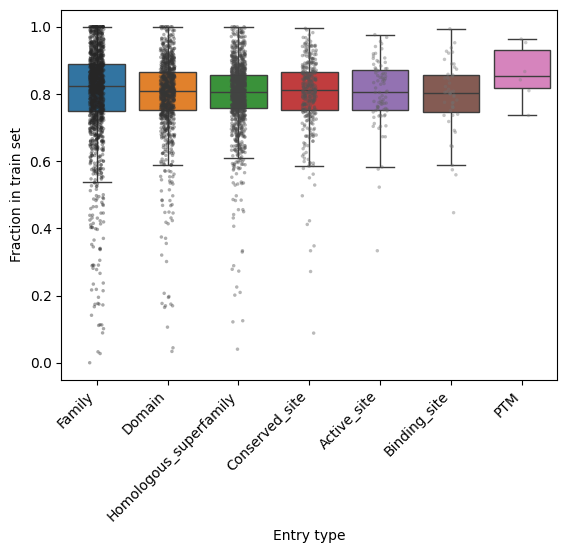

In [32]:
sns.boxplot(
    x="element_type",
    y="train_frac",
    hue="element_type",
    data=combined_counts_seq,
    hue_order=want_types,
    fliersize=0,
)
sns.stripplot(
    x="element_type",
    y="train_frac",
    hue="element_type",
    data=combined_counts_seq,
    hue_order=want_types,
    marker=".",
    alpha=0.4,
    color="grey",
)


plt.xticks(rotation=45, ha="right")
plt.ylabel("Fraction in train set")
plt.xlabel("Entry type")

Text(0.5, 0, 'Entry type')

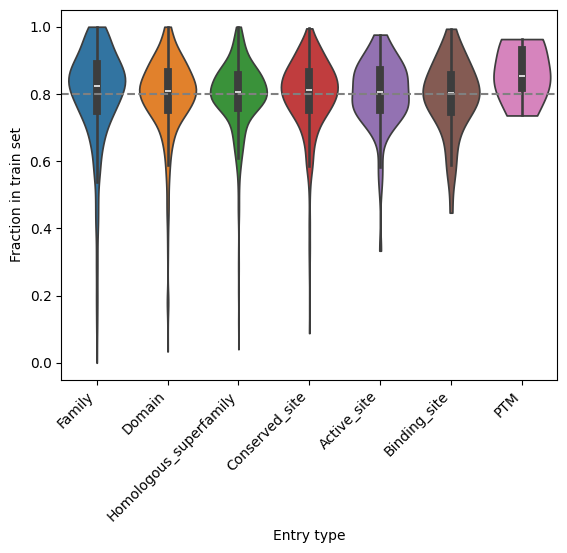

In [33]:
sns.violinplot(
    x="element_type",
    y="train_frac",
    hue="element_type",
    data=combined_counts_seq,
    hue_order=want_types,
    cut=0,
)
plt.axhline(0.8, color="gray", linestyle='--')

plt.xticks(rotation=45, ha="right")
plt.ylabel("Fraction in train set")
plt.xlabel("Entry type")

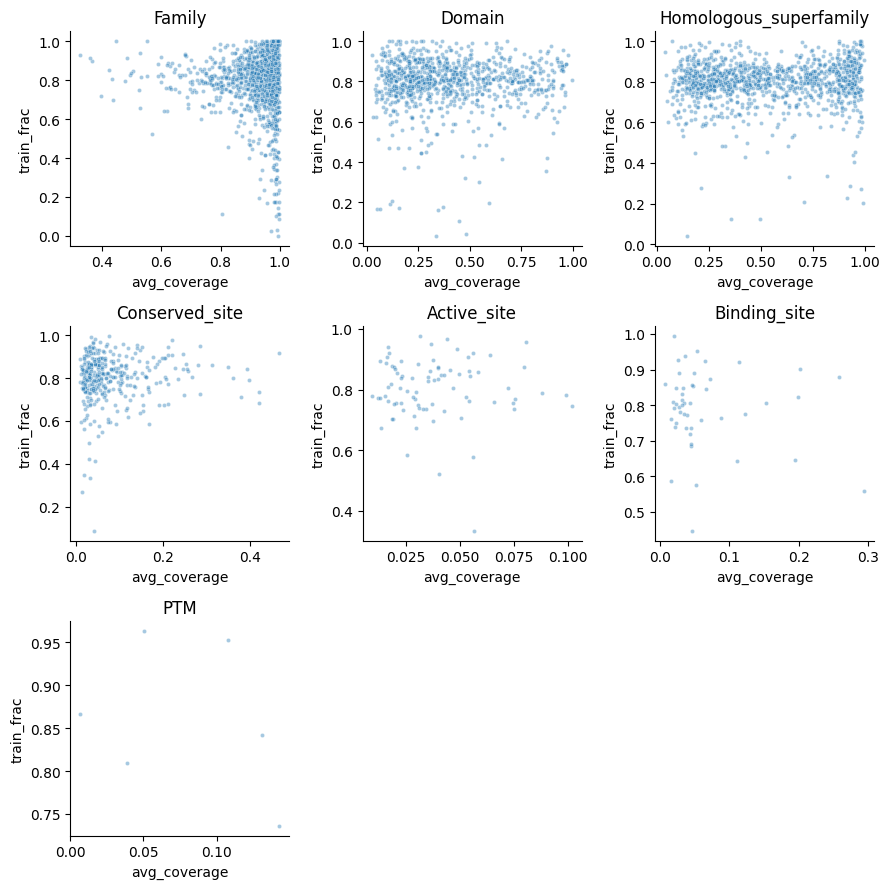

In [34]:
# Create a FacetGrid
g = sns.FacetGrid(combined_counts_seq, col="element_type", col_wrap=3, sharex=False, sharey=False)

# Define the plotting function
def plot_facet(data, **kwargs):
    elem_type = data['element_type'].iloc[0]

    sns.scatterplot(
        x="avg_coverage",
        y="train_frac",
        marker=".",
        alpha=0.4,
        data=data,
        **kwargs,
    )
    plt.title(elem_type)

# Map the plotting function to each facet
g.map_dataframe(plot_facet)

# Adjust titles to show only the element type
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title)

#plt.suptitle("Unique elements by threshold")

# Adjust layout
plt.tight_layout()
plt.show()